In contrast to the previous notebook, here, we will make use of the convolutional layer (CNN) to construct a tineVGG-like network to improve image classification. Convolutional layers have been known to learn the patterns present in the image data that fully-connected networks (with or without non-linear activations) are unable to learn efficiecntly and accurately within  feasible time and computation requirement.

In [1]:
import torch, torchvision
torch.__version__, torchvision.__version__

('2.0.0+cu118', '0.15.1+cu118')

In [2]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [3]:
from timeit import default_timer as timer

#### Getting torchvision dataset
`torchvision` provides some datasets that we can import to train our models. Here, we will use FashionMNIST dataset for demonstration. The returned variable is of type `Dataset` and has both features and the label of the sample at each index of the dataset.

In [4]:
train_data = torchvision.datasets.FashionMNIST(root="data",
                                               train=True, # download only training dataset
                                               download=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               target_transform=None)

test_data = torchvision.datasets.FashionMNIST(root="data",
                                               train=False, # download only test dataset
                                               download=True,
                                               transform=torchvision.transforms.ToTensor(),
                                               target_transform=None)

In [5]:
first_image, first_targe_label = train_data[0]
first_image.shape, first_targe_label

(torch.Size([1, 28, 28]), 9)

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1c9d538fa30>,
 <torch.utils.data.dataloader.DataLoader at 0x1c9d538f5b0>)

Let's see how to interact with the dataloader. As mentioned before, `DataLoader` turns our dataset into a Python iterable.

In [7]:
len(train_dataloader), len(test_dataloader)

(938, 157)

In [8]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch

(torch.Size([64, 1, 28, 28]),
 tensor([8, 3, 7, 0, 3, 6, 6, 0, 5, 2, 7, 7, 0, 4, 9, 3, 5, 6, 8, 2, 3, 8, 6, 2,
         8, 9, 5, 9, 7, 3, 6, 3, 3, 0, 3, 3, 5, 1, 4, 1, 9, 5, 3, 0, 4, 5, 5, 7,
         0, 4, 7, 6, 3, 9, 2, 9, 6, 6, 3, 4, 0, 7, 2, 0]))

Turns out, the `DataLoader` class converts the torchvision dataset features into the shape of B x C x H x W.

#### Build a Convoluational Neural Network.
Here, we will attempt to make classification of images based on CNN layers. We will create multiple CNN blocks such that they can be stacked one after the other.

In [9]:
class FashionMNIST_CNN_classifier(torch.nn.Module):
    """
    A torch model that looks similar to tiny VGGNet.
    """
    def __init__(self, in_channels: int, hidden_units : int, output_shape : int):
        super().__init__()
        
        self.conv_block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=hidden_units,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=hidden_units,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=hidden_units,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier_layer = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=  10 * 7 * 7, # calculated by printing the output of the previous block
                            out_features=output_shape)
        )

        

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.classifier_layer(self.conv_block_2(self.conv_block_1(x)))

#### Training
Train the network using `DataLoader` object. The training loop algorithm looks as below:<br>
- Loop through epochs.
    - for training batch 0 to ...
        - calculate `training_loss` for this batch using loss function.
        - calculate gradients using `loss.backward()`.
        - update parameters using `optimizer.step()`.
    - for testing batch 0 to ...
        - calculate `test_loss` for this batch.
        

In [10]:
from helper_functions import accuracy_fn
from utils import print_training_time

from tqdm import tqdm

In [11]:
len(train_dataloader)

938

Checking output format before training.


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
# create a classifier.
# shape of a FashionMNIST image is 28*28 and there are 10 different output labels.
torch.manual_seed(42)
torch.cuda.manual_seed(42)
_classifier = FashionMNIST_CNN_classifier(in_channels = 1, hidden_units=10, output_shape=10)
_classifier = _classifier.to(device=device)

with torch.inference_mode():
    _classifier.eval()
    for batch_num, (X, y) in enumerate(train_dataloader):
        # move the data to the respective device
        X, y = X.to(device=device), y.to(device=device)
        y_pred_batch = _classifier(X)
        break
# check the shape of the batch output
y_pred_batch.shape

torch.Size([64, 10])

#### Training and Testing
We use the modular versions of training and testing loops here.

In [14]:
# create a classifier.
# shape of a FashionMNIST image is 28*28 and there are 10 different output labels.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

classifier = FashionMNIST_CNN_classifier(in_channels = 1, hidden_units=10, output_shape=10)
classifier = classifier.to(device=device)
classifier


FashionMNIST_CNN_classifier(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [15]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= classifier.parameters(), lr= 0.01)

# import modular training and test loops
from utils import training_step
from utils import test_step

epochs = 30
epochs_ctr = []
avg_tr_loss_per_batch_list = []
avg_tr_acc_per_batch_list = []
avg_test_loss_per_batch_list = []
avg_test_acc_per_batch_list = []

total_training_time = 0.

for epoch in range(0, epochs):
    
    epoch_training_time_start = timer()

    print("\n*******Epoch ", epoch, "*******")
    epochs_ctr.append(epoch)
    cumulative_training_loss_per_epoch = 0
    cumulative_tr_acc_per_epoch = 0

    ### modular training step ###
    avg_tr_acc_per_batch, avg_tr_loss_per_batch = training_step(model=classifier,
                                                                data_loader=train_dataloader,
                                                                loss_function=loss_function,
                                                                optimizer=optimizer,
                                                                accuracy_func= accuracy_fn,
                                                                device=device)

    # store average loss and accuracy for plot
    avg_tr_acc_per_batch_list.append(avg_tr_acc_per_batch)
    avg_tr_loss_per_batch_list.append(avg_tr_loss_per_batch)

    ### modular test loop ###
    avg_test_acc_per_batch, avg_test_loss_per_batch = test_step(model=classifier,
                                                                data_loader=test_dataloader,
                                                                loss_function=loss_function,
                                                                accuracy_func=accuracy_fn,
                                                                device=device)
          
    # store average loss and accuracy for plot
    avg_test_loss_per_batch_list.append(avg_test_loss_per_batch)
    avg_test_acc_per_batch_list.append(avg_test_acc_per_batch)

    
    # calculate epoch training time
    epoch_training_end_time = timer()
    epoch_training_time = print_training_time(start=epoch_training_time_start, end=epoch_training_end_time, device=str(next(classifier.parameters())))
    total_training_time += epoch_training_time

# print total training time
print("\nTotal training time: ", total_training_time)


*******Epoch  0 *******
Avg tr loss/batch:  1.362 , Avg tr acc/batch:  51.019
Avg test loss/batch: 0.749 , Average test acc/batch: 72.512
Epoch training time: 12.85 seconds.

*******Epoch  1 *******
Avg tr loss/batch:  0.672 , Avg tr acc/batch:  75.68
Avg test loss/batch: 0.686 , Average test acc/batch: 76.035
Epoch training time: 13.237 seconds.

*******Epoch  2 *******
Avg tr loss/batch:  0.571 , Avg tr acc/batch:  79.261
Avg test loss/batch: 0.577 , Average test acc/batch: 78.643
Epoch training time: 11.35 seconds.

*******Epoch  3 *******
Avg tr loss/batch:  0.499 , Avg tr acc/batch:  82.09
Avg test loss/batch: 0.487 , Average test acc/batch: 82.594
Epoch training time: 11.541 seconds.

*******Epoch  4 *******
Avg tr loss/batch:  0.455 , Avg tr acc/batch:  83.807
Avg test loss/batch: 0.463 , Average test acc/batch: 83.848
Epoch training time: 11.291 seconds.

*******Epoch  5 *******
Avg tr loss/batch:  0.427 , Avg tr acc/batch:  84.67
Avg test loss/batch: 0.49 , Average test acc/b

#### Evaluate the trained model.

In [16]:
from utils import eval_model
eval_model(model=classifier.to("cpu"),
           data_loader=test_dataloader,
           loss_fn=loss_function,
           accuracy_fn=accuracy_fn)

{'model_name': 'FashionMNIST_CNN_classifier',
 'model_loss': 0.3248606026172638,
 'model_acc': 88.47531847133757}

As seen above, the CNN-based network has surpassed the performance of the previous FCN-based model, reaching beyond 86% test accuracy at one point.

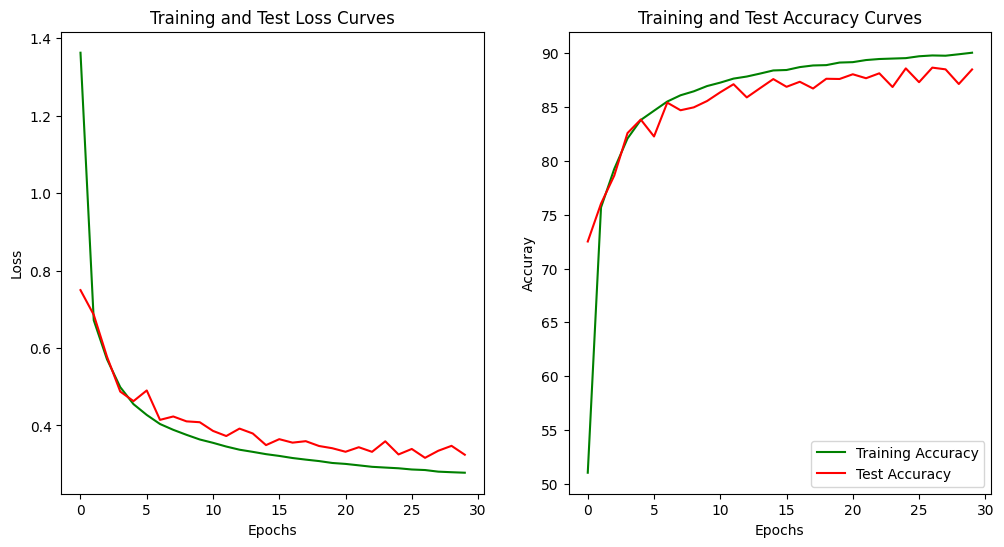

In [17]:
plt.figure(figsize=(12,6))

# subplot 1
plt.subplot(1,2,1) 
plt.title("Loss")
plt.plot(epochs_ctr, avg_tr_loss_per_batch_list, "g", label = "Training Loss")
plt.plot(epochs_ctr, avg_test_loss_per_batch_list, "r", label = "Test Loss")
plt.title("Training and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# subplot 2
plt.subplot(1,2,2)
plt.title("Test")
plt.title("Accuracy")
plt.plot(epochs_ctr, avg_tr_acc_per_batch_list, "g", label = "Training Accuracy")
plt.plot(epochs_ctr, avg_test_acc_per_batch_list, "r", label = "Test Accuracy")
plt.title("Training and Test Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuray")

plt.legend()
plt.show()

As seen above, our CNN-based model has beaten the test acccuracy of the previous FCN-based model.

Let's visualize the predictions.